Feature importances: [0.02953378 0.09022688 0.03534491 0.01890039 0.82599403]


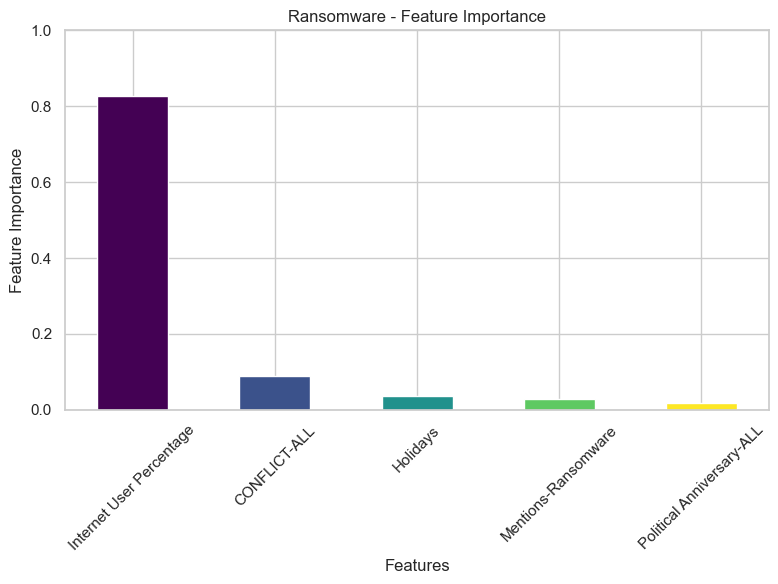

Selected feature indices: ['Internet User Percentage', 'CONFLICT-ALL']
Shape of selected_data: (153, 3)
Selected Parameters: {'alpha': 0.3, 'attack': 'Ransomware-ALL', 'batch_size': 4, 'beta': 0.4, 'epoch': 200, 'l2_reg': 0.07005619323359298, 'lr': 0.000703479973871023, 'n_features': 3, 'n_input': None, 'rdo': 0.2870691090357917, 'unit': [100]}
--------------------------------------------------------------------------------
Smoothing with alpha=0.3, beta=0.4


<Figure size 640x480 with 0 Axes>

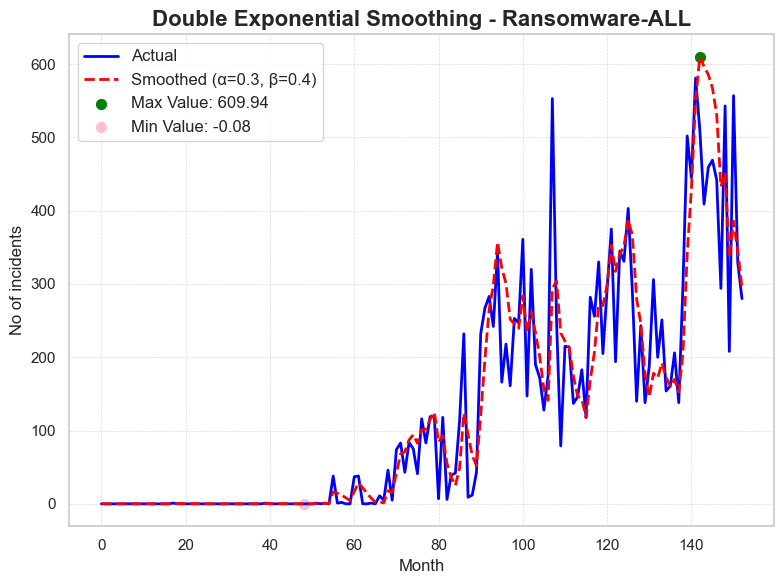

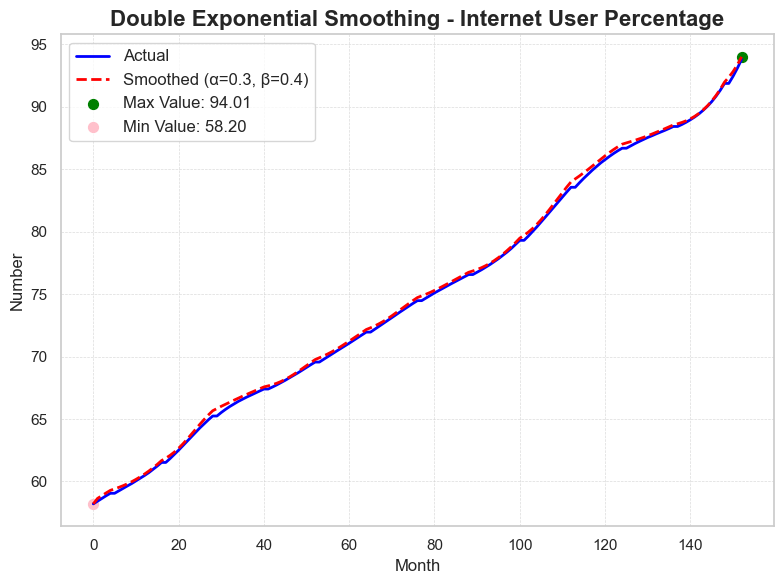

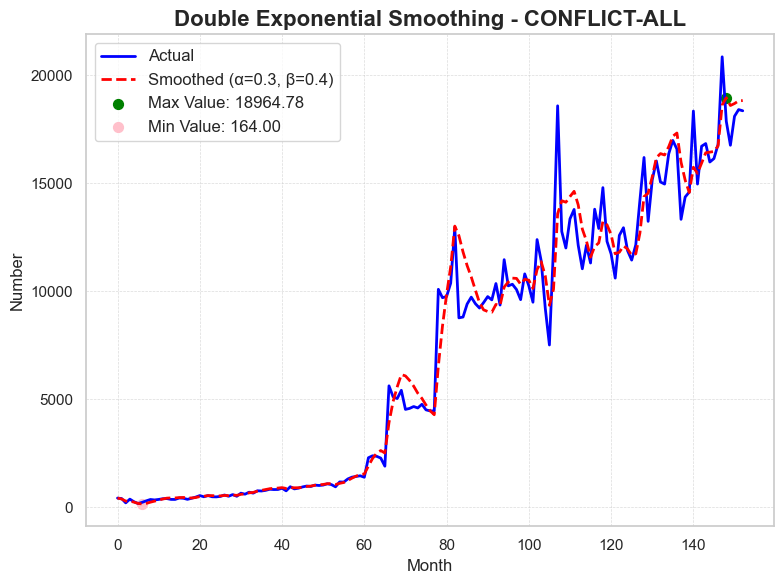

data shape= (153, 3)
Emerging Index= 0
Length of data after cut= 153


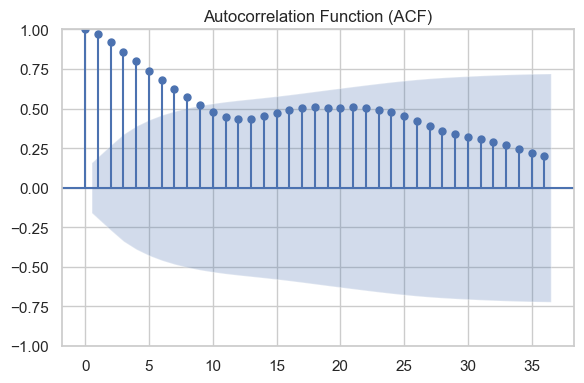

Optimal Lag: 16
(137, 16, 3)


c:\Users\hshar\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
c:\Users\hshar\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 145: ReduceLROnPlateau reducing learning rate to 0.00014069599565118553.

Epoch 150: ReduceLROnPlateau reducing learning rate to 2.8139198548160493e-05.

Epoch 155: ReduceLROnPlateau reducing learning rate to 5.627839709632099e-06.
Epoch 155: early stopping


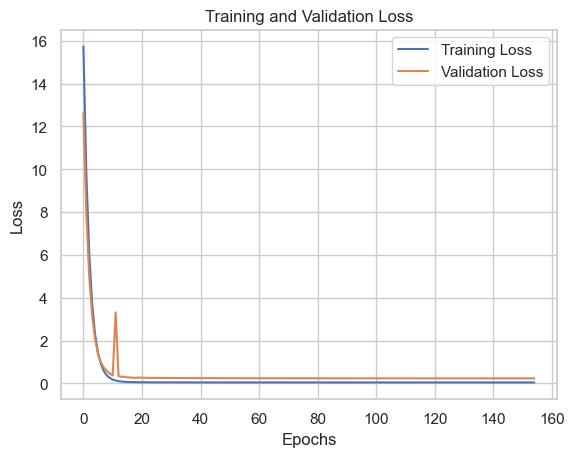

Selected Parameters: {'alpha': 0.3, 'attack': 'Ransomware-ALL', 'batch_size': 4, 'beta': 0.4, 'epoch': 200, 'l2_reg': 0.07005619323359298, 'lr': 0.000703479973871023, 'n_features': 3, 'n_input': 16, 'rdo': 0.2870691090357917, 'unit': [100]}
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/ste

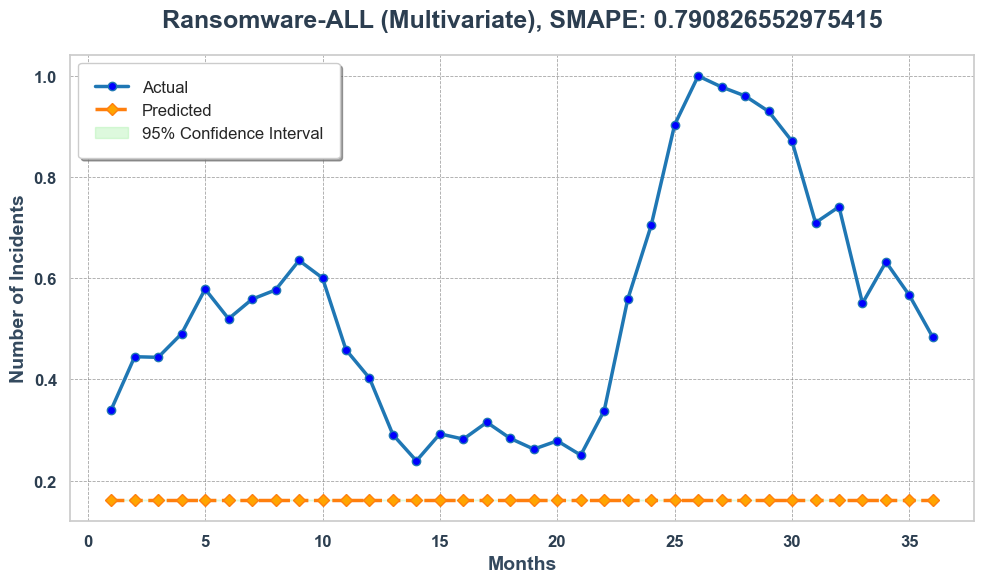

-----------End of Iteration 2--------------------------
Selected Parameters: {'alpha': 0.3, 'attack': 'Ransomware-ALL', 'batch_size': 4, 'beta': 0.4, 'epoch': 200, 'l2_reg': 0.07005619323359298, 'lr': 0.000703479973871023, 'n_features': 3, 'n_input': None, 'rdo': 0.2870691090357917, 'unit': [100]}
--------------------------------------------------------------------------------
Smoothing with alpha=0.3, beta=0.4


<Figure size 640x480 with 0 Axes>

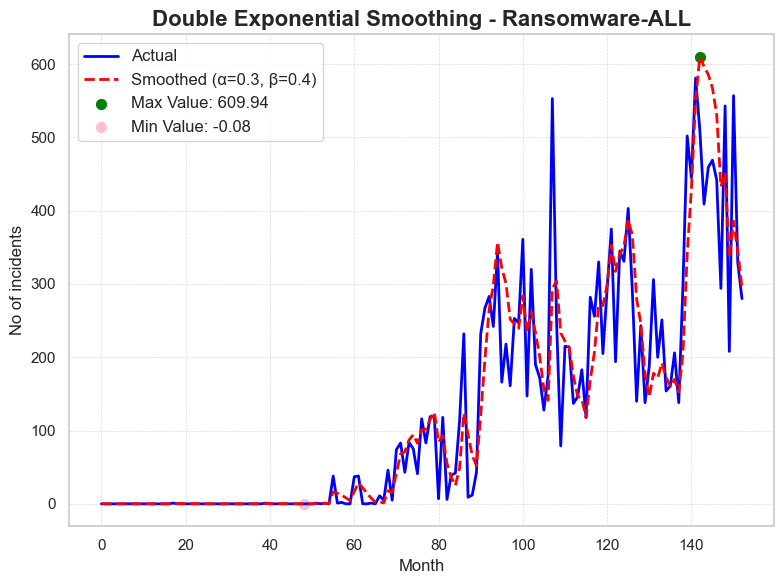

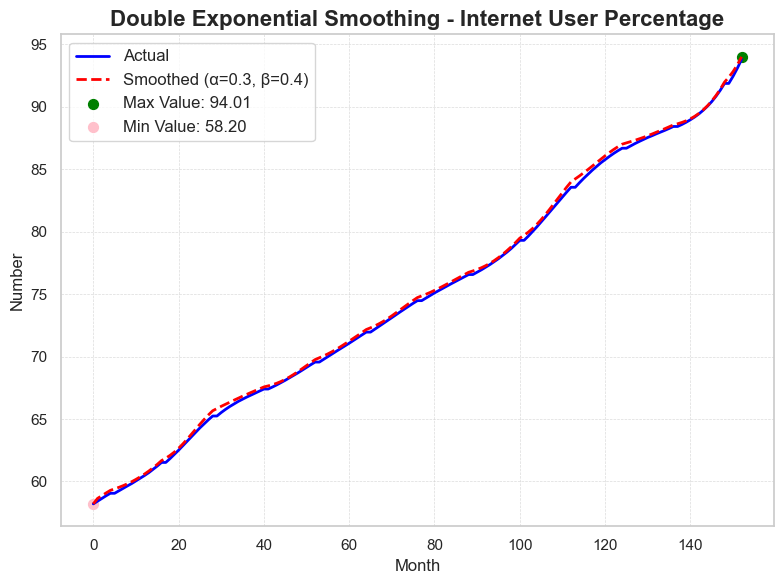

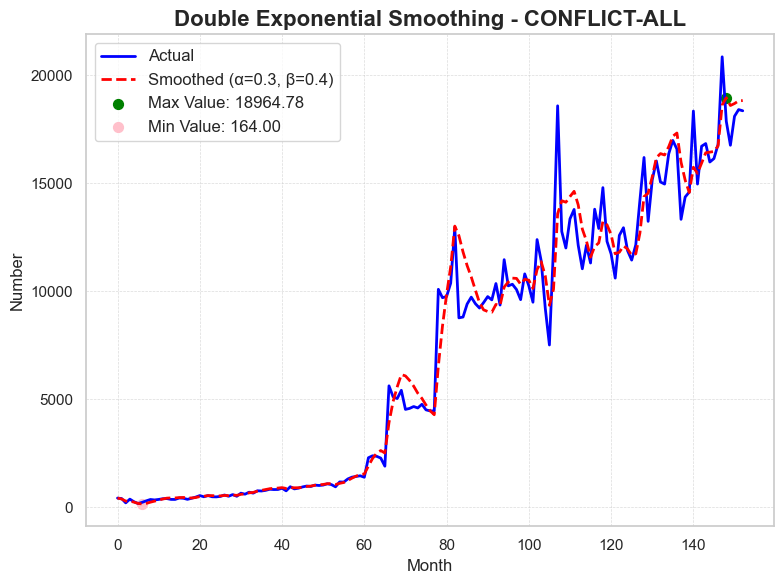

data shape= (153, 3)
Emerging Index= 0
Length of data after cut= 153


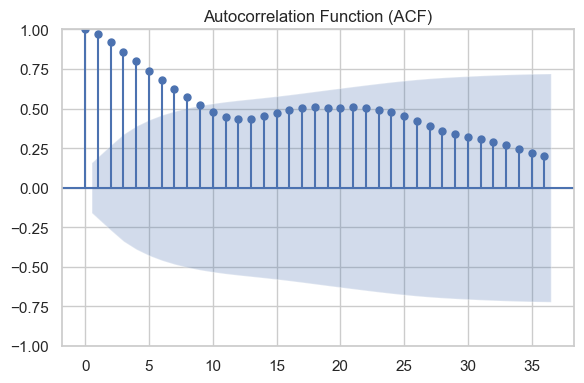

Optimal Lag: 16
(137, 16, 3)


c:\Users\hshar\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
c:\Users\hshar\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Epoch 23: ReduceLROnPlateau reducing learning rate to 0.00014069599565118553.

Epoch 32: ReduceLROnPlateau reducing learning rate to 2.8139198548160493e-05.

Epoch 40: ReduceLROnPlateau reducing learning rate to 5.627839709632099e-06.

Epoch 45: ReduceLROnPlateau reducing learning rate to 1.1255679055466317e-06.
Epoch 45: early stopping


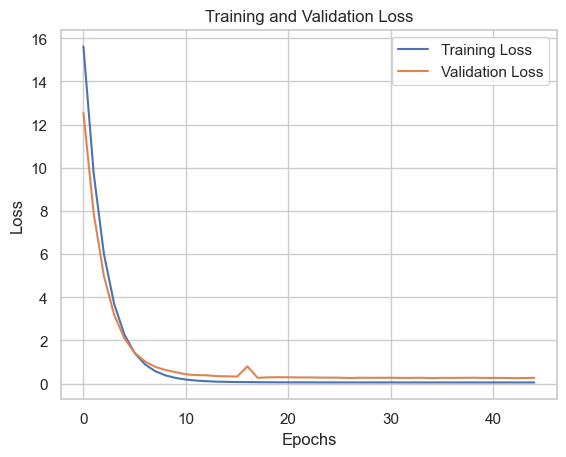

Best Parameters:  {'alpha': 0.3, 'attack': 'Ransomware-ALL', 'batch_size': 4, 'beta': 0.4, 'epoch': 200, 'l2_reg': 0.07005619323359298, 'lr': 0.000703479973871023, 'n_features': 3, 'rdo': 0.2870691090357917, 'unit': [100]}
Best Average SMAPE:  0.790826552975415


<Figure size 640x480 with 0 Axes>

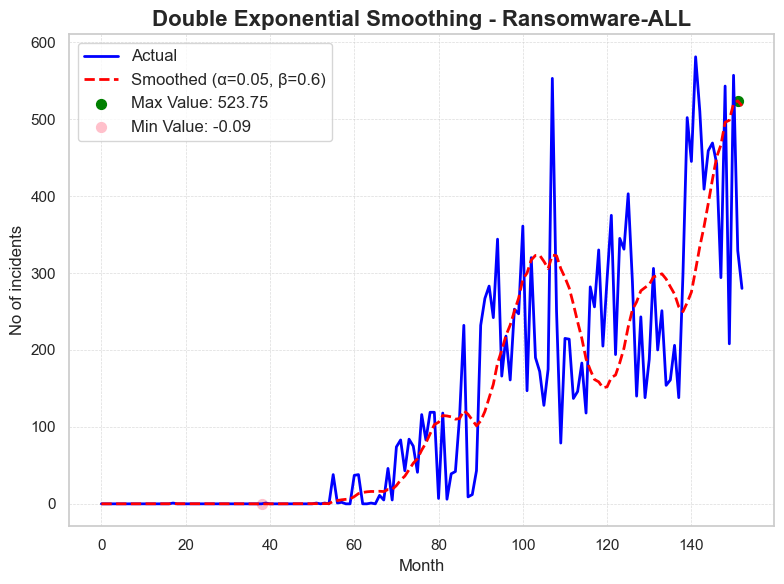

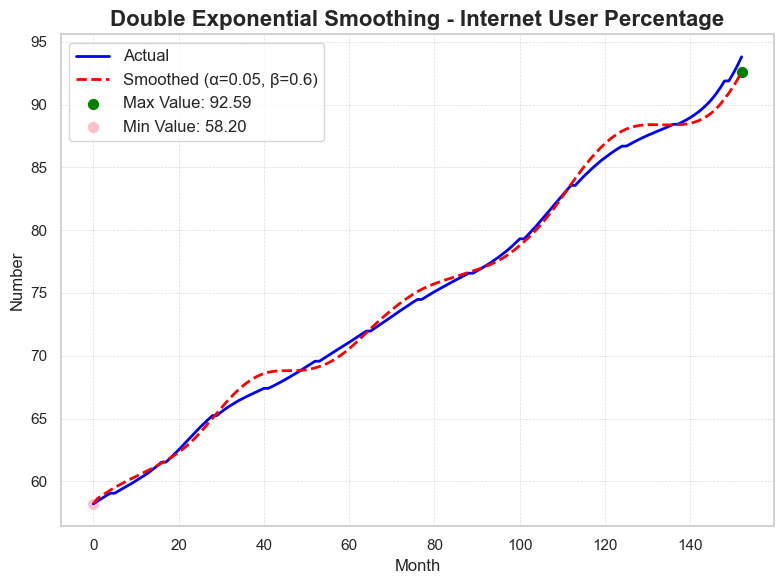

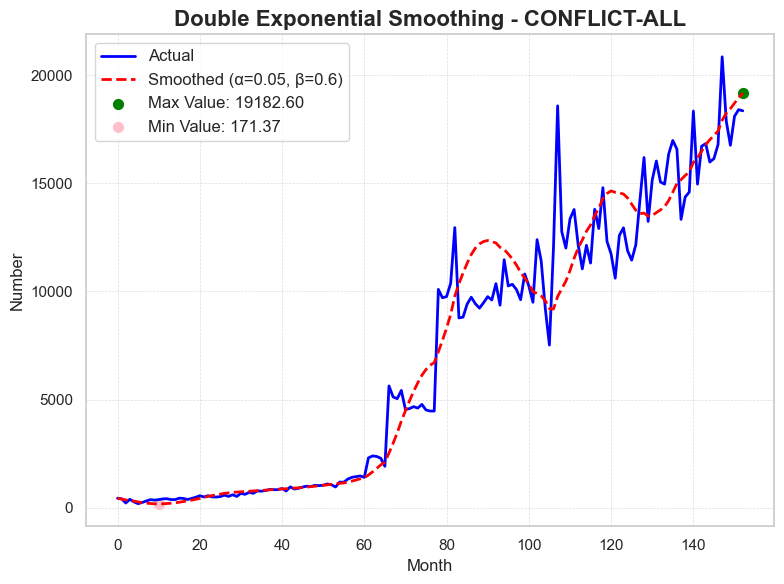

data shape= (153, 3)
Emerging Index = 0
Length of data after cut = 153


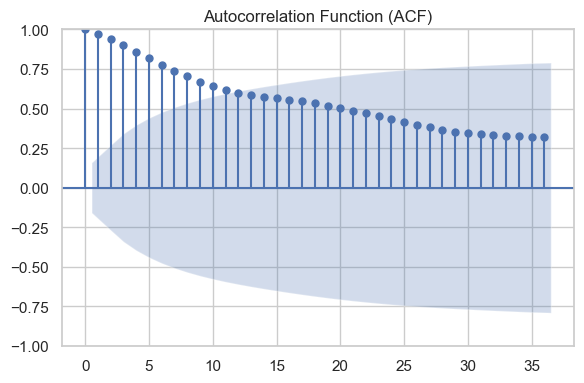

Optimal Lag: 16
(137, 16, 3)


c:\Users\hshar\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
c:\Users\hshar\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


KeyboardInterrupt: 

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf
import seaborn as sns
import csv
import tensorflow_probability as tfp
from pandas import read_csv
from matplotlib import pyplot as plt
import numpy as np
import os
import sys
import seaborn as sns
import pandas as pd
import math
from numpy import split
import random
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error
from scipy.optimize import minimize
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import numpy
from tqdm import tqdm_notebook
from keras.callbacks import EarlyStopping
from scipy.stats import loguniform, uniform, randint
from sklearn.preprocessing import MinMaxScaler
from numpy import array
#from itertools import product
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Layer
from keras.layers import Flatten
from keras.layers import LSTM
from keras.layers import RepeatVector
from keras.layers import TimeDistributed,BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras import optimizers
from tensorflow import keras
import tensorflow as tf
from numpy.random import seed
from scipy import stats
from IPython.display import clear_output
import statistics
import ast

import keras.backend as K
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer
from scipy.signal import find_peaks
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel
from tensorflow.keras import Input, Model

sns.set(style="whitegrid")



import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor

def model_based_feature_selection(df, target_column, num_features,attack_title):
    # Separate target and predictors
    target = df[target_column].values
    predictors = df.drop(columns=[target_column]).values
    feature_names = df.drop(columns=[target_column]).columns.tolist()

    model = RandomForestRegressor(n_estimators=500, random_state=42)
    model.fit(predictors, target)

    # Print feature importances for debugging
    feature_importances = model.feature_importances_
    print(f"Feature importances: {feature_importances}")

    # Get the indices of the top features based on importance
    indices = np.argsort(feature_importances)[::-1]
    top_indices = indices[:num_features]  # Indices of the top features

    # Select the features using the indices
    selected_data = np.zeros((predictors.shape[0], num_features + 1))  # Prepare the array with the correct shape
    selected_data[:, 0] = target  # First column is the target feature
    selected_data[:, 1:] = predictors[:, top_indices]  # Remaining columns are the selected features

    # Get the feature names of the top selected features
    selected_feature_names = [feature_names[i] for i in top_indices]

    # Plot feature importances for all features
    fig, ax = plt.subplots(figsize=(8, 6))
    colors = plt.cm.viridis(np.linspace(0, 1, len(feature_importances)))  # Different colors for each bar
    ax.bar(range(len(feature_importances)), feature_importances[indices], color=colors, width=0.5)
    ax.set_ylabel('Feature Importance')
    ax.set_xlabel('Features')
    ax.set_title(f'{attack_title} - Feature Importance')
    ax.set_ylim(0, 1)  # Limit y-axis to 1
    ax.set_xticks(range(len(feature_importances)))  # Ensure x-ticks match the number of bars
    ax.set_xticklabels([feature_names[i] for i in indices], rotation=45)  # Rotate x labels for better visibility
    plt.tight_layout()  # Adjust layout to prevent clipping
    plt.show()

    return selected_data, selected_feature_names



# evaluation mertic (symmteric mean absolute percentage error)
def smape(yTrue,yPred):
  smape=0

  for i in range(len(yTrue)):
    smape+= abs(yTrue[i]-yPred[i])/ (abs(yTrue[i])+abs(yPred[i]))
  smape/=len(yTrue)

  return smape


# Dynamic Penalty Function - Calculate IQR-based penalty
def calculate_dynamic_iqr_penalty(actual, mean_predictions):
    """Calculate dynamic penalty based on IQR."""
    iqr_actual = np.percentile(actual, 75) - np.percentile(actual, 25)
    iqr_pred = np.percentile(mean_predictions, 75) - np.percentile(mean_predictions, 25)
    
    # Define the penalty dynamically based on the difference in IQRs
    if iqr_pred < iqr_actual:
        iqr_ratio = iqr_pred / iqr_actual
        penalty = (1 - iqr_ratio) * 0.3  # Penalty is proportional to IQR difference
        print(f'**** PENALIZED: +{penalty:.4f} ******')
        return penalty  # Return only the penalty
    else:
        return 0  # No penalty if predicted IQR is sufficient


def exponential_smoothing(series, alpha):
    smoothed_series = [series[0]]
    for i in range(1, len(series)):
        smoothed_series.append(alpha * series[i] + (1 - alpha) * smoothed_series[i-1])
    return smoothed_series

def des_smoothing(series, alpha, beta):
    """
    Applies Double Exponential Smoothing (DES) to a time series for both smoothing and forecasting.

    Parameters:
    series (list or array-like): The input time series data.
    alpha (float): Smoothing factor for the level (between 0 and 1).
    beta (float): Smoothing factor for the trend (between 0 and 1).

    Returns:
    list: The smoothed series with forecasted values.
    """

    # Initialize the smoothed series with the first value
    smoothed_series = [series[0]]

    for i in range(1, len(series) + 1):
        if i == 1:
            # Initial level and trend setup
            level = series[0]
            trend = series[1] - series[0]
        if i >= len(series):
            # If we're forecasting beyond the data, use the last smoothed value
            observation = smoothed_series[-1]
        else:
            # Otherwise, use the actual data
            observation = series[i]

        # Store the previous level for trend calculation
        previous_level = level

        # Update the level and trend using the smoothing factors
        level = alpha * observation + (1 - alpha) * (level + trend)
        trend = beta * (level - previous_level) + (1 - beta) * trend

        # Append the new smoothed value (level + trend)
        smoothed_series.append(level + trend)

    return smoothed_series


def determine_optimal_lag(series,max_lags,lags):
    """
    Determine the optimal lag for a time series using ACF and PACF.

    Parameters:
    series (array-like): The input time series data.
    max_lags (int): Maximum time window size or lag which is allowed
    lags: upto  these lags correlations will be identified
    Returns:
    int: The optimal lag to use for the model.
    """
    # Calculate ACF and PACF values
    acf_values = acf(series, nlags=lags)
    # pacf_values = pacf(series, nlags=lags)
    
    # Determine significance level
    significance_level = 1.96 / np.sqrt(len(series))
    
    # Find the first lag where ACF and PACF drop below the significance level
    optimal_lag_acf = np.where(np.abs(acf_values) < significance_level)[0]
    # optimal_lag_pacf = np.where(np.abs(pacf_values) < significance_level)[0]
    
    # Take the first occurrence or default to max_lags if not found
    optimal_lag_acf = optimal_lag_acf[0] if len(optimal_lag_acf) > 1 else max_lags
    # optimal_lag_pacf = optimal_lag_pacf[0] if len(optimal_lag_pacf) > 1 else max_lags
    
    # Select the maximum of ACF and PACF lags
    optimal_lag = min(optimal_lag_acf, max_lags)
    
    # Plot ACF and PACF for inspection
    fig, ax = plt.subplots(1, 1, figsize=(6, 4))
    plot_acf(series, lags=lags, ax=ax)
    ax.set_title('Autocorrelation Function (ACF)')
    # plot_pacf(series, lags=lags, ax=ax[1])
    # ax[1].set_title('Partial Autocorrelation Function (PACF)')
    plt.tight_layout()
    plt.show()
    
    print(f"Optimal Lag: {optimal_lag}")
    return optimal_lag



def create_multivariate_lagged_dataset(series, n_lags):
    """
    Create a dataset where each time step t uses the previous n_lags time steps of all features as inputs.

    Parameters:
    series (array-like): The input time series data with multiple features (shape: [num_samples, num_features]).
    n_lags (int): The number of previous time steps to use as inputs.

    Returns:
    X (numpy array): Input features of shape (num_samples, n_lags, num_features).
    y (numpy array): Output labels of shape (num_samples, num_features).
    """
    X, y = [], []

    # Ensure the series is a numpy array
    series = np.array(series)

    if series.ndim == 1:
      series = series.reshape(-1, 1)

    # Loop over the series and create input-output pairs
    for i in range(n_lags, len(series[:,0])):
        X.append(series[i-n_lags:i, :])  # The previous n_lags time steps for all features
        y.append(series[i, :])           # The current time step for all features

    return np.array(X), np.array(y)

#Bayesian LSTM
class BayesianLSTM(LSTM): #inherits LSTM but set training=True which keeps dropout on during test time.

    def __init__(self, units, **kwargs):
        super(BayesianLSTM, self).__init__(units, **kwargs)

    def build(self, input_shape):
        super(BayesianLSTM, self).build(input_shape)

    def call(self, inputs, training=None, **kwargs):
        # Call the parent class LSTM with training set to True
        return super(BayesianLSTM, self).call(inputs, training=True, **kwargs)

    def compute_output_shape(self, input_shape):
        if self.return_sequences:
            return (input_shape[0], input_shape[1], self.units)
        else:
            return (input_shape[0], self.units)

class InputAttention(Layer):
    def __init__(self, n_features, **kwargs):
        super(InputAttention, self).__init__(**kwargs)
        self.n_features = n_features

    def build(self, input_shape):
        self.W = self.add_weight(name='attention_weight', shape=(input_shape[-1], input_shape[-1]), initializer='glorot_uniform', trainable=True)
        self.b = self.add_weight(name='attention_bias', shape=(input_shape[-1],), initializer='zeros', trainable=True)
        self.s = self.add_weight(name='importance_score', shape=(input_shape[-1],input_shape[-1]), initializer='glorot_uniform', trainable=True)
        super(InputAttention, self).build(input_shape)

    def call(self, x):
        # Using TensorFlow operations
        uit = tf.tanh(tf.tensordot(x, self.W, axes=1) + self.b)
        ait = tf.tensordot(uit, self.s, axes=[[2],[0]])
        ait = tf.nn.softmax(ait, axis=-1)
        # ait = tf.expand_dims(ait, axis=-1)

        weighted_input = x * ait
        return weighted_input,ait



class TemporalAttention(Layer):
    def __init__(self, **kwargs):
        super(TemporalAttention, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name='temporal_attention_weight', shape=(input_shape[-1], input_shape[-1]), initializer='glorot_uniform', trainable=True)
        self.b = self.add_weight(name='temporal_attention_bias', shape=(input_shape[-1],), initializer='zeros', trainable=True)
        self.s = self.add_weight(name='importance_score', shape=(input_shape[-1],), initializer='glorot_uniform', trainable=True)
        super(TemporalAttention, self).build(input_shape)

    def call(self, x):
        # Using TensorFlow operations
        uit = tf.tanh(tf.tensordot(x, self.W, axes=1) + self.b)
        ait = tf.tensordot(uit, self.s, axes=1)
        ait = tf.nn.softmax(ait, axis=1)
        ait = tf.expand_dims(ait, axis=-1)
        weighted_input = x * ait
        return tf.reduce_sum(weighted_input, axis=1),ait



def build_model(data, n_input, layer, unit, epoch, lr, rdo, n_features, l2_reg, attack_title, batchsize):
    # Prepare data
    train_x, train_y = create_multivariate_lagged_dataset(data, n_input)
    
    # Define model inputs
    inputs = Input(shape=(n_input, n_features))
 
    # Input Attention Mechanism applied to the input features
    input_attention, input_attention_scores = InputAttention(n_features)(inputs)

    # Add LSTM and Attention Mechanism based on the number of layers
    if layer == 1:
        # First LSTM Encoder Layer  with L2 Regularization
        ec_layer1_output = BayesianLSTM(unit[0], input_shape=(n_input, n_features), 
                                   recurrent_dropout=rdo, return_sequences=True, 
                                   activation=keras.layers.LeakyReLU(alpha=0.2),
                                   kernel_regularizer=l2(l2_reg))(input_attention)
           
        # Batch Normalization after LSTM layer
        ec_layer1_output = BatchNormalization()(ec_layer1_output)
        
        # Temporal Attention Mechanism applied to the hidden states
        temporal_attention_output, temporal_attention_scores = TemporalAttention()(ec_layer1_output)

        repeated_vector = RepeatVector(1)(temporal_attention_output)

        # First LSTM Decoder Layer with L2 Regularization
        dc_layer1_output = BayesianLSTM(unit[0], activation=keras.layers.LeakyReLU(alpha=0.2), 
                                   return_sequences=True, recurrent_dropout=rdo,
                                   kernel_regularizer=l2(l2_reg))(repeated_vector)
        
        # Batch Normalization after Decoder LSTM
        dc_final_output = BatchNormalization()(dc_layer1_output)
        
    elif layer == 2:
        # First encoder  LSTM Layer with L2 Regularization
        ec_layer1_output = BayesianLSTM(unit[0], input_shape=(n_input, n_features), 
                                   recurrent_dropout=rdo, return_sequences=True, 
                                   activation=keras.layers.LeakyReLU(alpha=0.2),
                                   kernel_regularizer=l2(l2_reg))(input_attention)
        
        # Batch Normalization after first LSTM
        ec_layer1_output = BatchNormalization()(ec_layer1_output)
        
        # Second encoder LSTM Layer with L2 Regularization
        ec_layer2_output = BayesianLSTM(unit[1], activation=keras.layers.LeakyReLU(alpha=0.2), 
                                   return_sequences=True, recurrent_dropout=rdo,
                                   kernel_regularizer=l2(l2_reg))(ec_layer1_output)
        
        # Batch Normalization after second LSTM
        ec_layer2_output = BatchNormalization()(ec_layer2_output)
        
        # Temporal Attention Mechanism applied to the hidden states
        temporal_attention_output, temporal_attention_scores = TemporalAttention()(ec_layer2_output)
        repeated_vector = RepeatVector(1)(temporal_attention_output)

        # Decoder LSTM Layers with L2 Regularization
        dc_layer1_output = BayesianLSTM(unit[1], activation=keras.layers.LeakyReLU(alpha=0.2), 
                                   return_sequences=True, recurrent_dropout=rdo,
                                   kernel_regularizer=l2(l2_reg))(repeated_vector)
        
        # Batch Normalization after first Decoder LSTM
        dc_layer1_output = BatchNormalization()(dc_layer1_output)
        
        dc_layer2_output = BayesianLSTM(unit[0], activation=keras.layers.LeakyReLU(alpha=0.2), 
                                   return_sequences=True, recurrent_dropout=rdo,
                                   kernel_regularizer=l2(l2_reg))(dc_layer1_output)
        
        # Batch Normalization after second Decoder LSTM
        dc_final_output = BatchNormalization()(dc_layer2_output)

    # Output Layers with L2 Regularization (Common for both conditions)
    outputs = TimeDistributed(Dense(100, activation=keras.layers.LeakyReLU(alpha=0.2), 
                                    kernel_regularizer=l2(l2_reg)))(dc_final_output)
    final_output = TimeDistributed(Dense(n_features, kernel_regularizer=l2(l2_reg)))(outputs)

    # Create the encoder decoder model with input and temporal attention mechnaism with single input and multiple outputs
    model = Model(inputs=inputs, outputs=[final_output, input_attention_scores, temporal_attention_scores])

    # Compile the model
    opt = keras.optimizers.Adam(learning_rate=lr)
    model.compile(optimizer=opt, loss=['mse',None,None], metrics=['mape',None,None])

    # Early stopping and ReduceLROnPlateau callbacks
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
    reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6, verbose=1)

    # Fit the model
    print(train_x.shape)
    train_history = model.fit(train_x, train_y, epochs=epoch, batch_size=batchsize, 
                              validation_split=0.2, verbose=0, callbacks=[es, reduce_lr])

    # Plot training and validation loss
    plt.plot(train_history.history['loss'], label='Training Loss')
    plt.plot(train_history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig(f"Training_Results/Multivariate/{attack_title}.png")
    plt.show()

    # Return the model
    return model

def scale_data(data):
    scaler = MinMaxScaler(feature_range=(0, 1))
    #Normalising the columns
    scaled_data = scaler.fit_transform(data)
    return scaled_data
def smooth_and_plot_data(data, alpha,attack, n_features,features,beta=1):
    # Split the data into training and testing
    featureList=[]
    mention_as_feature=False
    plt.clf()
    if not alpha==1 and not beta==1:
        smoothed= des_smoothing(data[:,0], alpha,beta)
        smoothed=smoothed[0:-1] #remove the one future step forecast from des
        plt.figure(figsize=(8, 6))
        plt.plot(data[:, 0], label="Actual", color='blue', linestyle='-', linewidth=2)
        plt.plot(smoothed, label=f"Smoothed (α={alpha}, β={beta})", color="red", linestyle='--', linewidth=2)
        plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
        plt.title(f"Double Exponential Smoothing - {attack}", fontsize=16, fontweight='bold')
        plt.xlabel("Month", fontsize=12)
        if 'Mentions-' in attack:
            plt.ylabel("No of mentions")
        else:
            mention_as_feature= False
            plt.ylabel("No of incidents")
        # Highlighting the max point in the smoothed data
        max_val, min_val = np.max(smoothed), np.min(smoothed)
        max_index, min_index = np.argmax(smoothed), np.argmin(smoothed)
        plt.scatter(max_index, max_val, color='green', s=50, label=f'Max Value: {max_val:.2f}')
        plt.scatter(min_index, min_val, color='pink', s=50, label=f'Min Value: {min_val:.2f}')
        plt.tight_layout()
        plt.legend(loc="best", fontsize=12)
        plt.show() #plot the data and smoothed data
        featureList.append(smoothed)

        if mention_as_feature:
            smoothed= des_smoothing(data[:,1], alpha,beta)
            smoothed=smoothed[0:-1] #remove the one future step forecast from des
            smoothed = np.array(smoothed)
            plt.figure(figsize=(8, 6))

            # Plot Actual vs Smoothed
            plt.plot(data[:, 1], label="Actual", color='blue', linestyle='-', linewidth=2)
            plt.plot(smoothed, label=f"Smoothed (α={alpha}, β={beta})", color="red", linestyle='--', linewidth=2)
            max_val, min_val = np.max(smoothed), np.min(smoothed)
            max_index, min_index = np.argmax(smoothed), np.argmin(smoothed)
            plt.scatter(max_index, max_val, color='green', s=50, label=f'Max Value: {max_val:.2f}')
            plt.scatter(min_index, min_val, color='pink', s=50, label=f'Min Value: {min_val:.2f}')   

            # Customizations
            plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
            plt.title(f"Double Exponential Smoothing - {attack[:-4]}", fontsize=16, fontweight='bold')
            plt.xlabel("Month", fontsize=12)
            plt.ylabel("No of Mentions", fontsize=12)
            plt.tight_layout()
            plt.legend(loc="best", fontsize=12)

            # Show plot
            plt.show()
            featureList.append(smoothed)
            mention_as_feature= False
        for index,feature in enumerate(features,start=len(featureList)):
            smoothed= des_smoothing(data[:,index], alpha,beta)
            smoothed=smoothed[0:-1] #remove the one future step forecast from des
            plt.figure(figsize=(8, 6))
            plt.plot(data[:, index], label="Actual", color='blue', linestyle='-', linewidth=2)
            plt.plot(smoothed, label=f"Smoothed (α={alpha}, β={beta})", color="red", linestyle='--', linewidth=2)
            max_val, min_val = np.max(smoothed), np.min(smoothed)
            max_index, min_index = np.argmax(smoothed), np.argmin(smoothed)
            plt.scatter(max_index, max_val, color='green', s=50, label=f'Max Value: {max_val:.2f}')
            plt.scatter(min_index, min_val, color='pink', s=50, label=f'Min Value: {min_val:.2f}')
            plt.title(f"Double Exponential Smoothing - {feature}", fontsize=16, fontweight='bold')
            plt.xlabel("Month", fontsize=12)
            plt.ylabel("Number", fontsize=12)
            plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
            plt.tight_layout()
            plt.legend(loc="best", fontsize=12)
            plt.show()
            plt.close()
            featureList.append(smoothed)
    elif not alpha==1 and beta==1:
        smoothed= exponential_smoothing(data[:,0], alpha)
        smoothed=smoothed[0:-1] #remove the one future step forecast from des
        plt.figure(figsize=(8, 6))
        plt.plot(data[:, 0], label="Actual", color='blue', linestyle='-', linewidth=2)
        plt.plot(smoothed, label=f"Smoothed (α={alpha}, β={beta})", color="red", linestyle='--', linewidth=2)
        plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
        plt.title(f"Exponential Smoothing - {attack}", fontsize=16, fontweight='bold')
        plt.xlabel("Month", fontsize=12)
        if 'Mentions-' in attack:
            plt.ylabel("No of mentions")
        else:
            mention_as_feature= True
            plt.ylabel("No of incidents")
        # Highlighting the max point in the smoothed data
        max_val, min_val = np.max(smoothed), np.min(smoothed)
        max_index, min_index = np.argmax(smoothed), np.argmin(smoothed)
        plt.scatter(max_index, max_val, color='green', s=50, label=f'Max Value: {max_val:.2f}')
        plt.scatter(min_index, min_val, color='pink', s=50, label=f'Min Value: {min_val:.2f}')
        plt.tight_layout()
        plt.legend(loc="best", fontsize=12)
        plt.show() #plot the data and smoothed data
        featureList.append(smoothed)

        if mention_as_feature:
            smoothed= exponential_smoothing(data[:,1], alpha)
            smoothed=smoothed[0:-1] #remove the one future step forecast from des
            smoothed = np.array(smoothed)
            plt.figure(figsize=(8, 6))

            # Plot Actual vs Smoothed
            plt.plot(data[:, 1], label="Actual", color='blue', linestyle='-', linewidth=2)
            plt.plot(smoothed, label=f"Smoothed (α={alpha}, β={beta})", color="red", linestyle='--', linewidth=2)
            max_val, min_val = np.max(smoothed), np.min(smoothed)
            max_index, min_index = np.argmax(smoothed), np.argmin(smoothed)
            plt.scatter(max_index, max_val, color='green', s=50, label=f'Max Value: {max_val:.2f}')
            plt.scatter(min_index, min_val, color='pink', s=50, label=f'Min Value: {min_val:.2f}')   

            # Customizations
            plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
            plt.title(f"Exponential Smoothing - {attack[:-4]}", fontsize=16, fontweight='bold')
            plt.xlabel("Month", fontsize=12)
            plt.ylabel("No of Mentions", fontsize=12)
            plt.tight_layout()
            plt.legend(loc="best", fontsize=12)

            # Show plot
            plt.show()
            featureList.append(smoothed)
            mention_as_feature= False
        for index,feature in enumerate(features,start=len(featureList)):
            smoothed= exponential_smoothing(data[:,index], alpha)
            smoothed=smoothed[0:-1] #remove the one future step forecast from des
            plt.figure(figsize=(8, 6))
            plt.plot(data[:, index], label="Actual", color='blue', linestyle='-', linewidth=2)
            plt.plot(smoothed, label=f"Smoothed (α={alpha}, β={beta})", color="red", linestyle='--', linewidth=2)
            max_val, min_val = np.max(smoothed), np.min(smoothed)
            max_index, min_index = np.argmax(smoothed), np.argmin(smoothed)
            plt.scatter(max_index, max_val, color='green', s=50, label=f'Max Value: {max_val:.2f}')
            plt.scatter(min_index, min_val, color='pink', s=50, label=f'Min Value: {min_val:.2f}')
            plt.title(f"Exponential Smoothing - {feature}", fontsize=16, fontweight='bold')
            plt.xlabel("Month", fontsize=12)
            plt.ylabel("Number", fontsize=12)
            plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
            plt.tight_layout()
            plt.legend(loc="best", fontsize=12)
            plt.show()
            plt.close()
            featureList.append(smoothed)
    else:
        return data    
    featureList=numpy.transpose(featureList)
    prepared_data=numpy.array(featureList).reshape(-1,n_features)
    return prepared_data






def train_test_split(data, n_input):
  split_position = len(data) - (36 + n_input)
  if split_position <= 0:
    raise ValueError("n_input is too large for the dataset size.")
  train, test = data[:split_position], data[split_position:]
  return train,test
a= 0

def model_evaluation(data, attack, param_distributions, attack_title,n_iter,selected_features,best_smape):
    """
    Uses RandomizedSearchCV to evaluate the model multiple times (from scratch) for each hyperparameter combination.
    Each combination will be trained, evaluated, and SMAPE averaged over `repeats` iterations.
    It prints out the selected parameters, repeat index, and SMAPE, and also calculates and stores the 95% confidence interval.

    Parameters:
    data: The input data for evaluation after model based feature selection
    attack: The target column to focus on.
    param_distributions: Dictionary of hyperparameter distributions for RandomizedSearchCV.
    n_iter: Number of random selections for RandomizedSearchCV.
    repeats: Number of times to evaluate the model for each hyperparameter combination.
    selected_features: Selected feature names in a list

    Returns:
    best_model: The best performing model based on the mean SMAPE.
    best_params: The best hyperparameters.
    best_mape: The lowest average SMAPE achieved.
    """

    class BayesianLSTMEstimator(BaseEstimator, RegressorMixin):
        def __init__(self, alpha, beta, n_input,unit, epoch, lr, rdo, n_features, attack,l2_reg,batch_size):
            self.alpha = alpha
            self.beta = beta
            self.n_input = None
            self.unit = unit
            self.epoch = epoch
            self.lr = lr
            self.rdo = rdo
            self.n_features = n_features
            self.attack = attack
            self.train,self.test=None,None
            self.scaler=None
            self.scaled_data = None
            self.relevant_scaled_data=None
            self.l2_reg = l2_reg
            self.batch_size  = batch_size

        def fit(self, X, y=None):
            global a
            seed(a+1)
            tf.random.set_seed(a+1)


            print(f'Selected Parameters: {self.get_params()}')
            print('--------------------------------------------------------------------------------')
            print(f"Smoothing with alpha={self.alpha}, beta={self.beta}")
            smoothed_data = smooth_and_plot_data(X, self.alpha, self.attack, self.n_features, selected_features,self.beta)
            self.scaled_data = scale_data(smoothed_data)
            print('data shape=',self.scaled_data.shape)
            e_index=0 #emerging index
            for i in range(len(self.scaled_data[:,0])-2):
                if self.scaled_data[i,0]>0 and self.scaled_data[i+1,0]>0 and self.scaled_data[i+2,0]>0:
                    e_index=i
                    break
            print('Emerging Index=',e_index)

            self.relevant_scaled_data=self.scaled_data[e_index:,]
            print('Length of data after cut=',len(self.relevant_scaled_data[:,0]))
            max_lags = (len(self.relevant_scaled_data[:,0])//10)+1
            self.n_input = determine_optimal_lag(self.relevant_scaled_data[:,0],max_lags,36)
        
            self.train, self.test = train_test_split(self.relevant_scaled_data, self.n_input)
            # Build and fit the model
            self.model = build_model(self.relevant_scaled_data, self.n_input, len(self.unit), self.unit, self.epoch, self.lr, self.rdo, self.n_features, self.l2_reg,attack_title,self.batch_size)
            return self

        def predict(self, X, y=None):
          """
          Perform multiple iterations of predictions and calculate the mean,
          along with lower and upper bounds for uncertainty estimation.
          """
          n_iterations = 10  # Number of iterations for Monte Carlo sampling
          all_predictions = []
          initial_history = self.test[:self.n_input]  # Initial history for generating future predictions

          # Perform n_iterations of forecasting
          for _ in range(n_iterations):
              history = initial_history.copy()
              predictions = []

              # Rolling window prediction for the test set
              for _ in range(len(self.test) - self.n_input):
                  #index 0 because model return attentionn scores as well in output
                  y_pred = self.model.predict(history.reshape(1, history.shape[0], history.shape[1]))[0]
                  next_value = y_pred[0][0]  # Extract the forecasted value
                  predictions.append(next_value)

                  # Update the history by appending the new prediction
                  history = np.append(history, next_value).reshape(-1, self.n_features)[1:]

              all_predictions.append(predictions)

          # Convert to numpy array for statistical analysis
          all_predictions = np.array(all_predictions)
          # Compute the mean, and the 95% confidence intervals (2.5th and 97.5th percentiles)
          mean_forecast = np.mean(all_predictions, axis=0)
          lower_bound = np.percentile(all_predictions, 2.5, axis=0)
          upper_bound = np.percentile(all_predictions, 97.5, axis=0)
          return mean_forecast[:,0], lower_bound[:,0], upper_bound[:,0]


        def score(self, X, y=None):
            """
            evaluate the model on SMAPE 
            The average SMAPE is returned as the score in negative as it finds the best smape in increasing order of integer.
            """
            global a
            a=a+1
            print(f"Selected Parameters: {self.get_params()}")
            mean_predictions, lower_bound, upper_bound = self.predict(X)
            smape_score = smape(self.test[self.n_input:, 0], mean_predictions)
            # Apply dynamic IQR penalty
            penalty = calculate_dynamic_iqr_penalty(self.test[self.n_input:, 0], mean_predictions)
            final_score = smape_score + penalty  # Apply the penalty to SMAPE
        
            print(f"Initial SMAPE = {smape_score}, Penalty = {penalty},  Corrected SMAPE= {final_score}")
            global best_smape
            if final_score < best_smape:
                best_smape = final_score
            print(f'Best SMAPE uptill now: {best_smape}')               
            print(f"Current Iteration SMAPE = {final_score}")
            self.plot_predictions(mean_predictions, lower_bound, upper_bound,final_score,best_smape)
            print(f'-----------End of Iteration {a+1}--------------------------')
            return -final_score  # Negative because RandomizedSearchCV maximizes the score, but we want to minimize SMAPE

        def plot_predictions(self, mean_predictions, lower_bound, upper_bound,smape,best_smape):
            """
            Plot actual values, mean predictions, and 95% confidence intervals for the current repeat.

            Parameters:
            mean_predictions: Mean predictions for the current repeat.
            lower_bound: Lower bound of the 95% confidence interval.
            upper_bound: Upper bound of the 95% confidence interval.
            smape: current smape
            best_smape: best  smape until now
            """
            # mean_predictions = self.scaler.inverse_transform(mean_predictions.reshape(-1,3)).flatten()
            actual = self.test[self.n_input:,0]
            # lower_bound = self.scaler.inverse_transform(lower_bound.reshape(-1,3)).flatten()
            # upper_bound = self.scaler.inverse_transform(upper_bound.reshape(-1,3)).flatten()
            x = range(1, len(mean_predictions) + 1)
            plt.figure(figsize=(10, 6), facecolor='white')
            plt.plot(x, actual, label='Actual', color='#1f77b4', linestyle='-', linewidth=2.5, marker='o', markersize=6, markerfacecolor='blue')
            plt.plot(x, mean_predictions, label='Predicted', color='#ff7f0e', linestyle='--', linewidth=2.5, marker='D', markersize=6, markerfacecolor='orange')
            plt.fill_between(x, lower_bound, upper_bound, color='lightgreen', alpha=0.3, label='95% Confidence Interval')
            plt.grid(True, which='both', color='gray', linestyle='--', linewidth=0.6, alpha=0.7)
            plt.legend(loc="best", fontsize=12, fancybox=True, framealpha=1, shadow=True, borderpad=1)
            plt.title(f'{attack} (Multivariate), SMAPE: {smape}', fontsize=18, fontweight='bold', color='#2c3e50', pad=20)
            plt.xlabel("Months", fontsize=14, fontweight='bold', color='#34495e')
            plt.ylabel("Number of Incidents", fontsize=14, fontweight='bold', color='#34495e')
            plt.xticks(fontsize=12, fontweight='bold', color='#2c3e50')
            plt.yticks(fontsize=12, fontweight='bold', color='#2c3e50')
            plt.tight_layout()
            if smape < best_smape:
                plt.savefig(f"Evaluation Result/Multivariate/{attack_title}"+".png")
            plt.show()
            plt.gcf()

    dummy_y = np.zeros(len(data))

    # Initialize RandomizedSearchCV
    model = BayesianLSTMEstimator(alpha=None, beta=None, unit=None,epoch=None,n_input=None, lr=None, rdo=None, n_features=None, attack=None,l2_reg=None,batch_size=None)
    random_search = RandomizedSearchCV(
        estimator=model,
        param_distributions=param_distributions,
        n_iter=n_iter,
        cv=[(slice(None), slice(None))],  # No actual CV, just one pass
    )

    # Fit and find the best model
    random_search.fit(data, dummy_y)

    best_model = random_search.best_estimator_  # Best model based on the search
    best_params = random_search.best_params_
    best_mape = -random_search.best_score_  # Convert back to positive SMAPE
 
    print("Best Parameters: ", best_params)
    print("Best Average SMAPE: ", best_mape)

    return best_model, best_params, best_mape


import numpy as np
import matplotlib.pyplot as plt

def forecast(data, selected_features, best_params, attack,attack_title, repeat):
    """
    Forecast the next 36 months using the best model from RandomizedSearchCV.
    Perform 10 Monte Carlo iterations to account for uncertainty and calculate the mean forecast and confidence intervals.

    Parameters:
    - data: iNPUT DATA
    - Selected_Features: Features selected from the Random Forest Estimator
    - best_params: Best hyperparameters returned from RandomizedSearchCV.
    - attack_title: Title of the plot.
    - repeat: No of Iterations of foreacast
    """
    

    alpha = float(best_params['alpha'])
    beta = float(best_params['beta'])
    unit = [int(x) for x in best_params['unit']]
    epoch = int(best_params['epoch'])
    lr = float(best_params['lr'])
    rdo = float(best_params['rdo'])
    n_features = int(best_params['n_features'])
    attack = best_params['attack']
    l2_reg = float(best_params['l2_reg'])
    batch_size = int(best_params['batch_size'])

    # Initialize accumulators for Input and Temporal attention
    input_attention_accumulator = []
    temporal_attention_accumulator = []

    for repeat_iteration in range(repeat):
        seed(repeat_iteration)
        tf.random.set_seed(repeat_iteration)
        all_predictions = []
        input_attention_all_samples = []
        temporal_attention_all_samples = []

        smoothed_data = smooth_and_plot_data(data, alpha, attack, n_features, selected_features, beta)
        scaled_data = scale_data(smoothed_data)

        print('data shape=', scaled_data.shape)
        index = 0  # emerging index
        for i in range(len(scaled_data[:, 0]) - 2):
            if scaled_data[i, 0] > 0 and scaled_data[i + 1, 0] > 0 and scaled_data[i + 2, 0] > 0:
                index = i
                break
        print('Emerging Index =', index)

        relevant_scaled_data = scaled_data[index:,]
        print('Length of data after cut =', len(relevant_scaled_data[:, 0]))
        max_lags = (len(relevant_scaled_data[:, 0]) // 10) + 1
        n_input = determine_optimal_lag(relevant_scaled_data[:, 0], max_lags, 36)
        model = build_model(relevant_scaled_data, n_input, len(unit), unit, epoch, lr, rdo, n_features, l2_reg, attack_title, batch_size)

        # Perform 10 Monte Carlo iterations of forecasting
        for iteration in range(10):
            history = relevant_scaled_data[-n_input:].copy()  # Start with the last n_input historical data points
            predictions = []
            input_attention_per_iteration = []
            temporal_attention_per_iteration = []

            # Generate predictions for the next 36 months
            for _ in range(36):
                y_pred, input_attention_scores, temporal_attention_scores = model.predict(history.reshape(1, history.shape[0], history.shape[1]))
                next_value = y_pred[0][0]  # Extract the forecasted value
                predictions.append(next_value)

                # Collect InputAttention scores
                input_attention_avg_features = np.mean(input_attention_scores[0], axis=0)  
                input_attention_per_iteration.append(input_attention_avg_features)

                # Collect TemporalAttention scores
                temporal_attention_per_iteration.append(temporal_attention_scores[0].squeeze())

                # Update the history by appending the new prediction and removing the oldest value
                history = np.append(history, next_value).reshape(-1, n_features)[1:]

            # Store predictions for this iteration
            all_predictions.append(predictions)

            # Average InputAttention across samples (i.e., across all predictions)
            input_attention_all_samples.append(np.mean(np.array(input_attention_per_iteration), axis=0))

            # Average TemporalAttention across samples (i.e., across all predictions)
            temporal_attention_all_samples.append(np.mean(np.array(temporal_attention_per_iteration), axis=0))

        # Now plot the forecast along with the confidence intervals
        all_predictions = np.array(all_predictions)
        mean_forecasts = np.mean(all_predictions, axis=0)
        lower_bound = np.percentile(all_predictions, 2.5, axis=0)
        upper_bound = np.percentile(all_predictions, 97.5, axis=0)

        # Forecast Plot
        plot_forecast(mean_forecasts[:,0],lower_bound[:,0], upper_bound[:,0], attack_title, scaled_data[:, 0], repeat_iteration)

        # Accumulate the averages across all iterations
        input_attention_accumulator.append(np.mean(input_attention_all_samples, axis=0))
        temporal_attention_accumulator.append(np.mean(temporal_attention_all_samples, axis=0))

    # Final averages for InputAttention and TemporalAttention across all 10 iterations
    final_input_attention_avg = np.mean(np.array(input_attention_accumulator), axis=0)
    final_temporal_attention_avg = np.mean(np.array(temporal_attention_accumulator), axis=0)

    features=[attack] + selected_features
    plot_attention_scores(final_input_attention_avg,final_temporal_attention_avg,features)

    # Save the forecast results to a text file
    with open(f'Output Forecast/Multivariate/{attack_title.replace("/", "_")}_forecast.txt', 'w') as f:
        f.write(f"Mean Forecast: {mean_forecasts.tolist()}\n")
        f.write(f"Lower Bound (95% CI): {lower_bound.tolist()}\n")
        f.write(f"Upper Bound (95% CI): {upper_bound.tolist()}\n")




def plot_forecast(mean_forecasts, lower_bound, upper_bound, attack_title, historical_actual_data,a):
    """
    Plot the forecast with 95% confidence intervals, including historical data,
    from July 2011 to March 2024, followed by the forecast from April 2024 to March 2027.
    The x-axis will display yearly labels based on the number of data points.

    Parameters:
    - mean_forecasts: Mean forecasts for the next 36 months (April 2024 to March 2027).
    - lower_bound: Lower bound of the 95% confidence interval for the forecasts.
    - upper_bound: Upper bound of the 95% confidence interval for the forecasts.
    - attack_title: Title of the plot.
    - historical_data: Historical data (actual data) for the period from July 2011 to March 2024.
    - a: seed
    """
    total_data_points = len(historical_actual_data) + len(mean_forecasts)

    # Generate year labels starting from 2012, placed at every 12th tick (i.e., 9, 21, 33,...)
    years = ['2012'] + [str(2012 + (i // 12)) for i in range(12, total_data_points - 8, 12)]
    print(years)

    # Calculate the tick locations: starting from tick 9, every 12 ticks
    ticks = range(9, total_data_points+1, 12)

    # Set up the figure
    plt.figure(figsize=(14, 7), facecolor='white')

    # Plot historical data (July 2011 - March 2024)
    plt.plot(range(len(historical_actual_data)), historical_actual_data, label='Historical Data', color='royalblue', linestyle='-', linewidth=2)

    plt.plot(range(len(historical_actual_data) - 1, total_data_points), [historical_actual_data[-1]] + list(mean_forecasts), label='Forecast', color='orange', linestyle='--', linewidth=2)

    # Fill the 95% confidence interval for the forecasted data
    plt.fill_between(range(len(historical_actual_data), total_data_points), lower_bound, upper_bound, color='lightgreen', alpha=0.3, label='95% Confidence Interval')

    # Add grid lines only at the major ticks (where the labels are)
    plt.gca().set_xticks(ticks)  # Set major ticks only at labeled positions
    plt.grid(True, which='major', color='lightgray', linestyle='--', linewidth=0.8, alpha=0.9)

    # Add labels, title, and legend
    plt.legend(loc="best", fontsize=12, fancybox=True, framealpha=1, shadow=True, borderpad=1)
    plt.title(f'{attack_title} - Historical Data & 36 Months Forecast(Multivariate)', fontsize=18, fontweight='bold', color='#333333', pad=20)
    plt.xlabel("Year", fontsize=14, fontweight='bold', color='#333333')
    plt.ylabel("Number of Incidents", fontsize=14, fontweight='bold', color='#333333')

    # Set x-axis ticks to match the year labels and apply label formatting
    plt.xticks(ticks, years, rotation=45, fontsize=12, fontweight='bold', color='#333333')
    plt.yticks(fontsize=12, fontweight='bold', color='#333333')

    # Save the plot as PNG
    plt.tight_layout()
    plt.savefig(f"Output Forecast/Multivariate/{attack_title}_{a+1}.png")
    plt.show()
    plt.gcf()

def plot_attention_scores(input_attention_scores,temporal_attention_scores,features):
          
    features_str = [str(f) for f in features]
    print(features_str)

    # Plot Input Attention scores
    plt.figure(figsize=(5, 5))
    colors = plt.cm.viridis(np.linspace(0, 1, len(features)))
    plt.bar(features_str, input_attention_scores,color=colors, width=0.5)
    plt.title(f'Average Input Attention Scores (Feature-wise) - {attack_title}')
    plt.xlabel('Features')
    plt.ylabel('Average Attention Score')
    plt.xticks(rotation=45)  # Rotate x-axis labels if needed
    plt.tight_layout()  # Adjust layout to avoid clipping

    plt.show()
    # Plot Temporal Attention scores
    plt.figure(figsize=(6, 4))
    plt.plot(range(len(temporal_attention_scores)), temporal_attention_scores, marker='o')
    plt.title(f'Average Temporal Attention Scores (Time step-wise) - {attack_title}')
    plt.xlabel('Time Step (Hidden State)')
    plt.ylabel('Average Attention Score')
    plt.show()

data = pd.read_csv('Input/InputData.csv',header=0)

attack_list=['Ransomware-ALL','Cryptojacking-ALL','Mentions-Data Poisoning','Mentions-Deepfake', 'Mentions-WannaCry Ransomware','Mentions-Adversarial Attack']
for attack in attack_list:

#'CONFLICT-ALL','Holidays','Political Anniversary-ALL','Internet User Percentage'
  if 'Mentions' in attack:
    attack_title = attack[9:]
    input_data = data[[attack,'CONFLICT-ALL','Holidays','Political Anniversary-ALL','Internet User Percentage']]
  else:
    attack_title=attack[:-4]
    input_data = data[[attack,'Mentions-'+attack_title,'CONFLICT-ALL','Holidays','Political Anniversary-ALL','Internet User Percentage']]


  target_column = input_data.columns[0] 
  best_features_to_select =2 # Number of best features to select

  # Apply model-based feature selection to identify important features
  selected_input_data, selected_features = model_based_feature_selection(input_data, target_column, best_features_to_select,attack_title)

  # Output the selected features and shape
  print(f"Selected feature indices: {selected_features}")
  print(f"Shape of selected_data: {selected_input_data.shape}")

  param_distributions = {
    'alpha': [0.05, 0.1,0.15,0.2,0.3,0.5,0.7,1],  
    'beta': [0.4,0.6, 0.7,0.75,0.8,1],  
    'unit': [[32], [64], [100], [128], [256], [32,16], [64,32], [128,64], [256,128]], 
    'epoch': [50, 100, 150, 200],  
    'lr': loguniform(1e-4, 1e-3),  
    'rdo': uniform(0.1, 0.3),  
    'n_features': [selected_input_data.shape[1]], 
    'attack': [attack],  
    'l2_reg': uniform(0.01, 0.07),  
    'batch_size':[2,4,8]
  }   

  repeat=3
  best_smape = 0.999
  best_model,best_param, best_mape = model_evaluation(selected_input_data,attack,param_distributions,attack_title,1,selected_features,best_smape)
  if best_mape<best_smape:
    with open('Best_Hyperparams/Multivariate/'+attack_title.replace('/','_')+'.txt', 'w') as f:
        f.write('SMAPE: '+str(best_mape))
        f.write('\nHyperparams: '+str(best_param))
        f.close()


  ## Reading best hyperparam from the file  
  best_hyperparams=[]
  with open('Best_Hyperparams/Multivariate/'+attack_title.replace('/','_')+'.txt', 'r') as f:
    lines = f.readlines()
    smape_value = float(lines[0].split(":")[1].strip())  # Extract SMAPE value
    hyperparams_string = ":".join(lines[1:]).split(":", 1)[1].strip()  # Join all the lines after SMAPE and extract the dictionary
    best_hyperparams = ast.literal_eval(hyperparams_string)  # Safely evaluate the dictionary

  #Forecasting the threats using the best hyperparam from the file
  forecast(selected_input_data,selected_features,best_hyperparams,attack,attack_title ,repeat)








